### HW9

C:\Users\soo18\AppData\Local\Temp\ipykernel_22344\3449219817.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts.index = pd.to_datetime(ts.index)



 Summary Results: Comparison of Model Error Rates
                                Mean Squared Error
NN: 2 layers (2x2 nodes)              9.590142e+04
NN: 1 layer (2 nodes)                 9.658538e+04
OLS: fit all Country A                3.945529e+08
OLS: fit Half and predict half        8.601721e+08


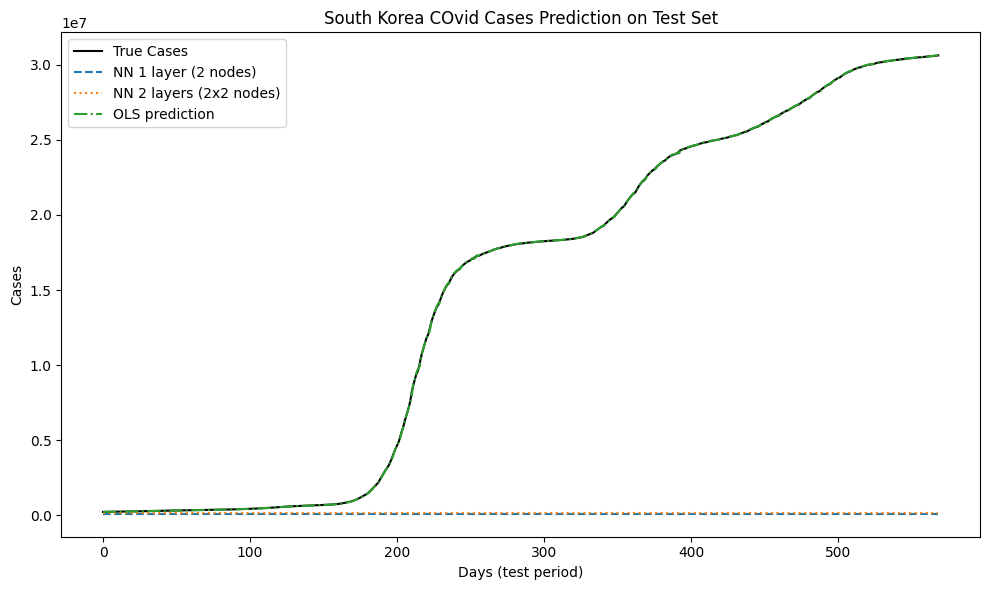

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

torch.set_float32_matmul_precision('medium')

path = r"C:\Users\soo18\OneDrive\Desktop\Data Science\homework-8-asherkim169\time_series_covid19_confirmed_global.csv"
df = pd.read_csv(path)

def prepare_country_data(df, country, k=5):
    country_df = df[df['Country/Region'] == country].drop(columns=['Province/State', 'Lat', 'Long'], errors='ignore')
    country_df = country_df.groupby('Country/Region').sum()
    ts = country_df.T
    ts.index = pd.to_datetime(ts.index)
    ts.columns = ['cases']
    first_nonzero_idx = (ts['cases'] > 0).idxmax()
    ts = ts.loc[first_nonzero_idx:].copy()
    ts['t'] = np.arange(len(ts))
    for lag in range(1, k+1):
        ts[f'Y_lag{lag}'] = ts['cases'].shift(lag)
    ts = ts.dropna().reset_index(drop=True)
    return ts

def fit_distributed_lag(ts, k=5):
    X = ts[[f'Y_lag{i}' for i in range(1, k+1)]]
    X = sm.add_constant(X)
    y = ts['cases']
    model = sm.OLS(y, X).fit()
    ts['y_pred'] = model.predict(X)
    ts['error'] = y - ts['y_pred']
    return model, ts

country_A = "Korea, South"
k = 5
A_data = prepare_country_data(df, country_A, k)

# Linear Regression using all data
model_A_all, A_all_pred = fit_distributed_lag(A_data, k)
mse_A_all = mean_squared_error(A_all_pred['cases'], A_all_pred['y_pred'])

split = len(A_data) // 2
train_A = A_data.iloc[:split].copy()
test_A = A_data.iloc[split:].copy()

X_train = sm.add_constant(train_A[[f'Y_lag{i}' for i in range(1, k+1)]])
y_train = train_A['cases']
model_half = sm.OLS(y_train, X_train).fit()

X_test = sm.add_constant(test_A[[f'Y_lag{i}' for i in range(1, k+1)]])
test_A['y_pred'] = model_half.predict(X_test)
test_A['error'] = test_A['cases'] - test_A['y_pred']
mse_A_half = mean_squared_error(test_A['cases'], test_A['y_pred'])

X_cols = [f'Y_lag{i}' for i in range(1, k+1)]
X_train_np = train_A[X_cols].values
y_train_np = train_A['cases'].values.reshape(-1, 1)
X_test_np = test_A[X_cols].values
y_test_np = test_A['cases'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_np)
y_train_scaled = scaler_y.fit_transform(y_train_np)
X_test_scaled = scaler_X.transform(X_test_np)
y_test_scaled = scaler_y.transform(y_test_np)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

# Linear regression using 1 hiddne layer and 2 nodes
class Net1(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )
    def forward(self, x): return self.net(x)

# Linear regression using 2 hiddne layer and 4 nodes
class Net2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 2),
            nn.ReLU(),
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )
    def forward(self, x): return self.net(x)

def train_nn(model, X_train, y_train, X_test, y_test, epochs=200, lr=0.01, patience=15):
    """Fast training with early stopping."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0
    best_preds = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = criterion(model(X_train), y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = model(X_test)
            test_loss = criterion(preds, y_test).item()

        if test_loss < best_loss:
            best_loss = test_loss
            best_preds = preds.clone()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    return best_loss, best_preds

input_dim = X_train_t.shape[1]
mse_results = {}

model1 = Net1(input_dim)
mse_nn1, preds1 = train_nn(model1, X_train_t, y_train_t, X_test_t, y_test_t)
mse_results["NN: 1 layer (2 nodes)"] = mse_nn1

model2 = Net2(input_dim)
mse_nn2, preds2 = train_nn(model2, X_train_t, y_train_t, X_test_t, y_test_t)
mse_results["NN: 2 layers (2x2 nodes)"] = mse_nn2

mse_results["OLS: fit all Country A"] = mse_A_all
mse_results["OLS: fit Half and predict half"] = mse_A_half

results_df = pd.DataFrame.from_dict(mse_results, orient='index', columns=['Mean Squared Error'])
print("\n Summary Results: Comparison of Model Error Rates")
print(results_df.sort_values(by='Mean Squared Error'))


preds1_denorm = scaler_y.inverse_transform(preds1.detach().numpy())
preds2_denorm = scaler_y.inverse_transform(preds2.detach().numpy())

plt.figure(figsize=(10,6))
plt.plot(y_test_np, label="True Cases", color='black')
plt.plot(preds1_denorm, label="NN 1 layer (2 nodes)", linestyle='--')
plt.plot(preds2_denorm, label="NN 2 layers (2x2 nodes)", linestyle=':')
plt.plot(test_A['y_pred'].values, label="OLS prediction", linestyle='-.')
plt.title("South Korea COvid Cases Prediction on Test Set")
plt.xlabel("Days (test period)")
plt.ylabel("Cases")
plt.legend()
plt.tight_layout()
plt.show()
